<a href="https://colab.research.google.com/github/mineoran/Data-Science-Bootcamp/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Traffic Time Series Forecasting

- Zaman serileri günlük hayatta en sık karşılaşılan veri türlerinden biridir. Zaman serisini, bir veya daha fazla değişkenin ardışık zaman periyotlarını günlük, haftalık, mevsimlik ve yıllık gibi farklı ölçeklerdeki kalıpların bir kombinasyonu olarak düşünebiliriz. Bu projede ele alacağımız web traffic veri seti ile birlikte zaman serisi modellerini, her biri aylara yayılan Wikipedia makalelerinin günlük görüntülenme sayısını içeren zaman serisi verilerinden oluşan bir eğitim setini eğiteceğiz.

- Veri seti, Kaggle'daki Web Trafiği Zaman Serileri Tahmini yarışmasından Kaggle alınmıştır. Eğitim veri seti yaklaşık 145 bin zaman serisinden oluşmaktadır. Bu zaman serilerinin her biri, 1 Temmuz 2015'ten 31 Aralık 2016'ya kadar farklı bir Wikipedia makalesinin günlük görünümlerini temsil eder.

In [5]:
#Veri setlerini Drive üzerinden alıyoruz;
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



## Gerekli Kütüphanelerin Kurulumu 



## Verilere Genel Bakış
Bu bir Kaggle yarışması olduğundan veri seti, bize train.csv,key.csv,sample_submission.csv içinde üç dosya veriliyor.

train.csv, her biri farklı bir Wikipedia sayfasını temsil eden yaklaşık 145k satır içerir ve her sütunun bir tarihi temsil eder.İlk sütun, Wikipedia sayfasının dilini içeren sayfanın adını içerir. Örneğin İngilizce için en.wilipedia.org, İspanyolca için es.wikipedia.org..
key.csv, Bu dosyada iki sütun vardır: 'page name' ve 'id'. 'train.csv' dosyasında bulunan her sayfa adı için key.csv dosyasında 62 satırımız var, bu 62 satır her sayfa için 62 günlük tahmine karşılık geliyor. Her sayfa adı için karşılık gelen kimlik vardır.

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from pandas import Series
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
from tensorflow import keras 

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True) 

In [7]:
df = pd.read_csv('/content/gdrive/My Drive/project/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


- Sütunlar, 1 Temmuz 2015 ile 31 Aralık 2016 arasında değişen günlük tarihlerdir. Dolayısıyla her bir zaman serisi 551 gün uzunluğundadır.

## Eksik Değerler
Zaman serisi verileri düzensiz zaman aralıklarında oluşabilir. Bu, verilerin sıklığını yeniden örnekleme ihtiyacını yaratır. Neyse ki, sağlanan veriler eşittir ve tüm zaman serileri aynı zaman aralığına sahiptir. Ancak NaN ile doldurulmuş birçok boş değer olduğunu gözlemliyoruz. Eksik bir değer, trafiğin sıfır olduğunu veya verilerin o gün için mevcut olmadığını gösterebilir.Bu veri setinin veri kaynağı, sıfır trafik değerleri ile eksik değerler arasında ayrım yapmaz. Eksik bir değer, trafiğin sıfır olduğu veya o gün için verilerin mevcut olmadığı anlamına gelebilir.

Zaman serileri için eksik değerlerin çıkarılması yaygın olarak kullanılan bir yöntem.Eksik değerlerle ilgili netliğin olmaması nedeniyle, veri seti zaman serisi modellemesi için yeterince büyük olduğundan, boş değerlere sahip bu zaman serilerini güvenle göz ardı edebiliriz.


In [8]:
df.isna().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [9]:
new_dataset = df.loc[~df.isnull().any(axis=1)]

In [10]:
new_dataset.shape

(117277, 551)

In [11]:
new_dataset

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144944,Chichén_Itzá_es.wikipedia.org_all-access_spider,8.0,13.0,19.0,14.0,6.0,5.0,10.0,9.0,5.0,...,15.0,18.0,12.0,6.0,5.0,14.0,10.0,174.0,8.0,19.0
144945,Fecundación_es.wikipedia.org_all-access_spider,29.0,16.0,6.0,11.0,33.0,4.0,11.0,16.0,10.0,...,8.0,8.0,13.0,3.0,6.0,10.0,16.0,10.0,7.0,8.0
144946,Gran_Hermano_VIP_(España)_es.wikipedia.org_all...,4.0,25.0,7.0,11.0,6.0,6.0,16.0,11.0,23.0,...,12.0,299.0,46.0,5.0,11.0,77.0,523.0,110.0,171.0,43.0
144947,Modelo_atómico_de_Thomson_es.wikipedia.org_all...,0.0,2.0,6.0,6.0,7.0,5.0,4.0,6.0,7.0,...,13.0,1.0,5.0,11.0,9.0,11.0,6.0,7.0,9.0,4.0


-  <p> Eksik değer satırlarını çıkardıktan sonra idexlerde bir kayma görüyoruz , yeniden indeksleme işlemi işin aşağıdaki kodu kullanmamz gerekiyor; <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html"> Pandas Reset Index</a> 

In [12]:
new_dataset = new_dataset.reset_index().drop(['index'], axis=1)
new_dataset

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117272,Chichén_Itzá_es.wikipedia.org_all-access_spider,8.0,13.0,19.0,14.0,6.0,5.0,10.0,9.0,5.0,...,15.0,18.0,12.0,6.0,5.0,14.0,10.0,174.0,8.0,19.0
117273,Fecundación_es.wikipedia.org_all-access_spider,29.0,16.0,6.0,11.0,33.0,4.0,11.0,16.0,10.0,...,8.0,8.0,13.0,3.0,6.0,10.0,16.0,10.0,7.0,8.0
117274,Gran_Hermano_VIP_(España)_es.wikipedia.org_all...,4.0,25.0,7.0,11.0,6.0,6.0,16.0,11.0,23.0,...,12.0,299.0,46.0,5.0,11.0,77.0,523.0,110.0,171.0,43.0
117275,Modelo_atómico_de_Thomson_es.wikipedia.org_all...,0.0,2.0,6.0,6.0,7.0,5.0,4.0,6.0,7.0,...,13.0,1.0,5.0,11.0,9.0,11.0,6.0,7.0,9.0,4.0


## Keşifsel Veri Analizi & Veri Görselleştirme
100 binden fazla zaman serisi verimiz var, hepsini tek tek analiz etmek imkansız olduğu için bu zaman serilerini bölmemiz gerekir.Page sütununu zaman serilerini analiz etmek için kullanacağız. İlk sütun, Wikipedia sayfasının dilini içeren sayfanın adıdır.(Örneğin, İngilizce için en.wilipedia.org, İspanyolca için es.wikipedia.org,zh, Çince için wikipedia.org) + type of access(masaüstü için) , tüm erişim) +agent (örümcek, gerçek trafik). Örneğin bir ad- 'AKB48_zh.wikipedia.org_all-access_spider'.

İlk olarak sayfanın dilini adından çıkarıp ve bir kümeye eklemekle başlayacağız, böylece yalnızca benzersiz girişimiz olur ve veri kümesindeki toplam dil sayısını kolayca bulabiliriz.

In [13]:
#Sayfa adresini dilleri ayıracak şekilde bölüyoruz.
df.Page.str.rsplit('_').str.get(-3).unique()

array(['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org',
       'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org',
       'de.wikipedia.org', 'ja.wikipedia.org', 'es.wikipedia.org'],
      dtype=object)

In [14]:
import re

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

df['lang'] = df.Page.map(get_language)

In [15]:
from collections import Counter

print(Counter(df.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


- <p> 7 dil vardır. Burada kullanılan diller : İngilizce, Japonca, Almanca, Fransızca, Çince, Rusça ve İspanyolca.
- <p> Wikipedia'da kullanılan farklı dillerin veri kümesini nasıl etkileyebileceğini inceleyelim.

In [16]:
#Farklı girdi türleri için veri çerçeveleri oluşturduk.Daha sonra tüm görünümlerin toplamını hesaplayacağız.
#Veriler birkaç farklı kaynaktan geliyor, toplama hesabında muhtemelen bazı görünümleri iki kez sayacaktır.

lang_sets = {}
lang_sets['en'] = df[df.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = df[df.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = df[df.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = df[df.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = df[df.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = df[df.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = df[df.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = df[df.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

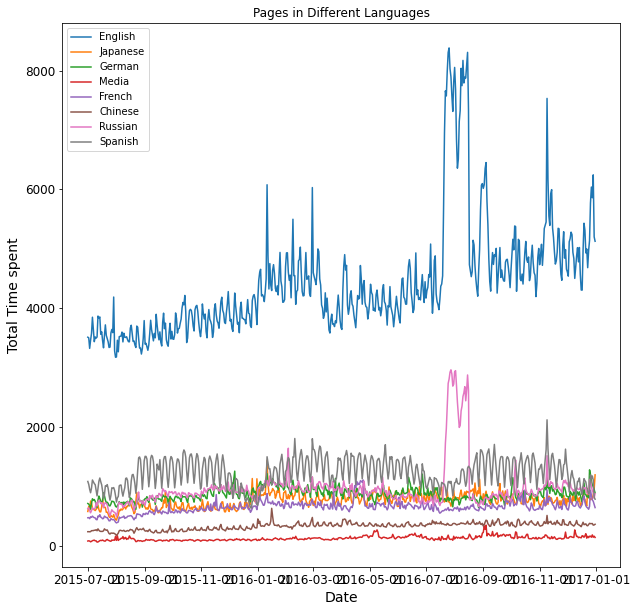

In [17]:
import matplotlib.dates as mdates
import datetime as dt
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Total Time spent')
plt.xlabel('Date')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df.columns[1:551]]
for key in sums:
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.plot(x,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

- Beklenilen gibi, İngilizce Vikipedi aramaları tüm diller arasında en büyük trafiğe sahiptir ancak Ağustos 2016 civarında bir örüntü vardır ve ilginç bir şekilde Rusça Vikipedi'de aynı örüntüye sahiptir. Ayrıca İngilizce Wikipedia'da Ocak 2016 civarında bir model var ve aynı dönemde Japonca wiki'de de bazı ani yükselişler görülebilir.

- Sonuç olarak web sitesinde tercih edilen dillere göre web trafiğinde farklılık vardır.

In [18]:
#Web sitersindeki görütülenmelerin dillere göre grafiği;

def plot_with_views(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Total time spent')
    plt.xlabel('Dates')
    plt.title(labels[key])
    plt.plot(x,sums[key],label = labels[key] )
    plt.show()

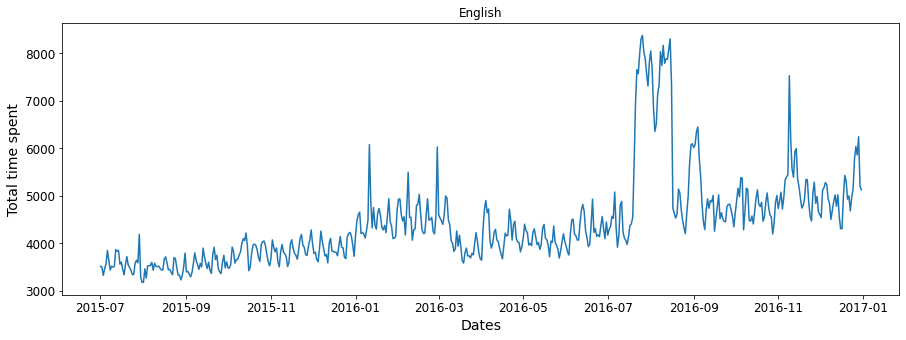

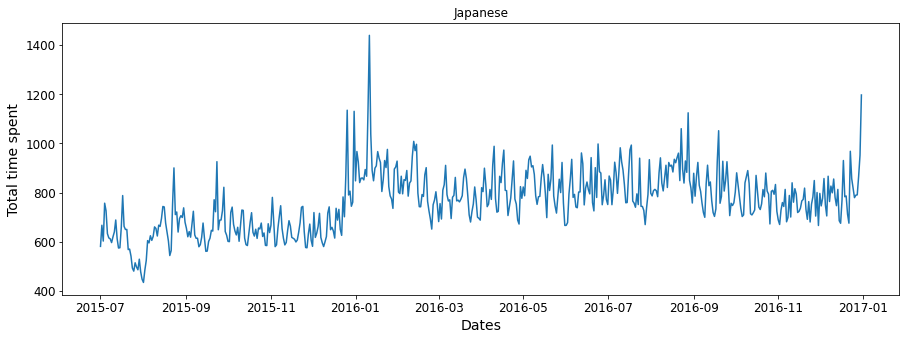

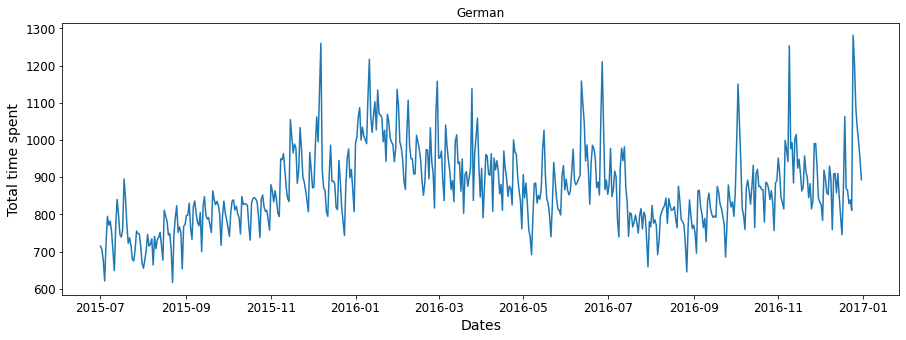

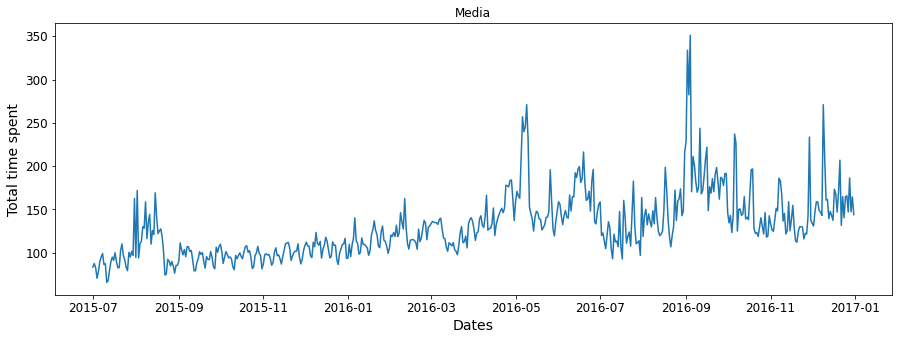

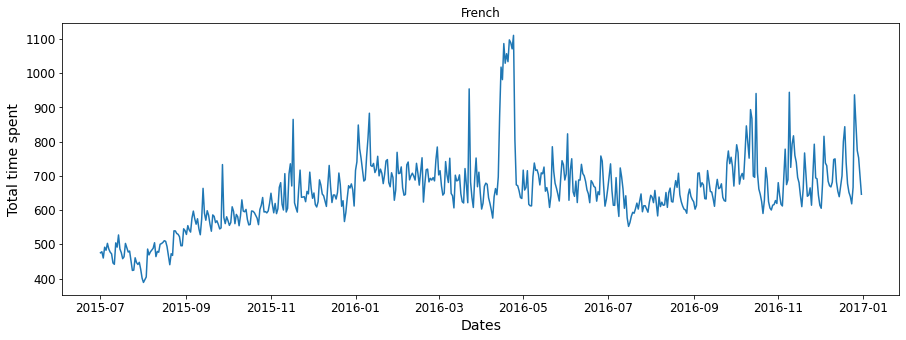

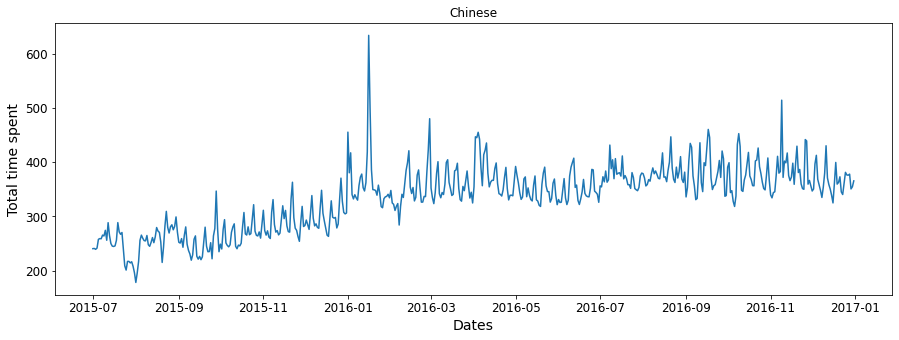

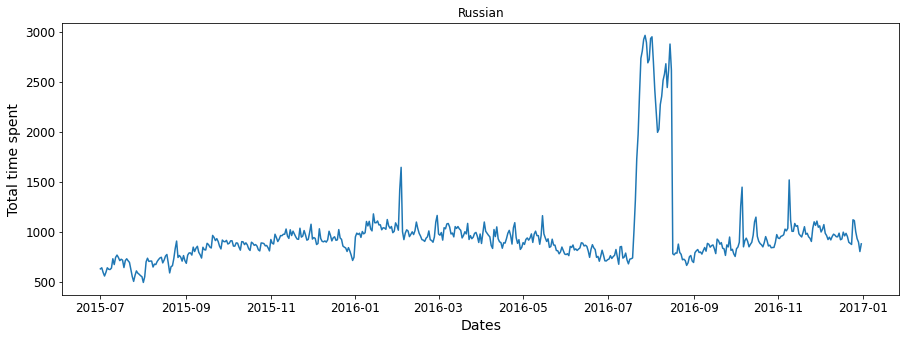

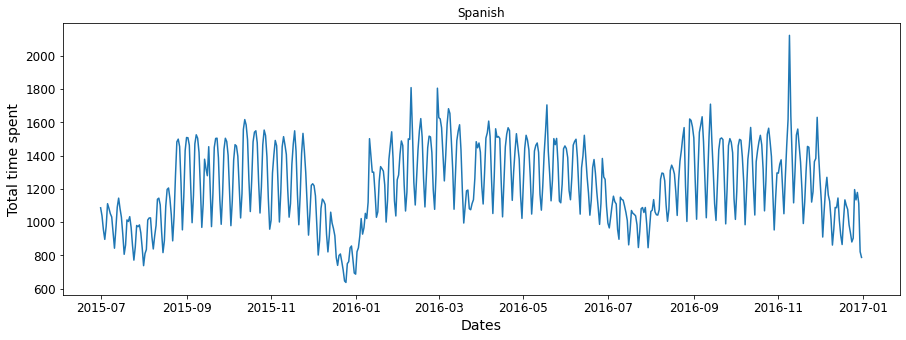

In [19]:
for key in sums:
    plot_with_views(key)

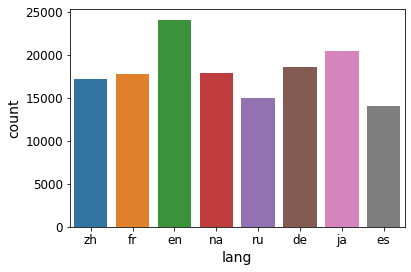

In [20]:
import seaborn as sb
sb.countplot(df['lang'])
plt.show()

- <p> Veri Seti hakkında genel bir fikre sahip olduktan sonra, page kolonunu kaldırabiliriz.

In [21]:
new_dataset_copy = new_dataset.copy()
new_dataset = new_dataset.drop(['Page'], axis=1)
new_dataset.head(10)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
5,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,32.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
6,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,22.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
7,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,15.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0
8,2.0,1.0,4.0,4.0,2.0,6.0,3.0,6.0,9.0,11.0,...,8.0,17.0,18.0,48.0,19.0,14.0,9.0,23.0,11.0,7.0
9,2.0,5.0,5.0,1.0,3.0,3.0,5.0,3.0,17.0,3.0,...,5.0,4.0,4.0,5.0,2.0,9.0,7.0,4.0,5.0,0.0


 - Zamanları gösteren sütun adlarını, verileri daha sonra işlememize yardımcı olacak tarihlerden zaman adımlarına çeviriyoruz.

In [22]:
new_dataset.columns = [ i for i,x in enumerate(new_dataset.columns)]
    
new_dataset.head(10)

,0,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
5,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,32.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
6,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,22.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
7,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,15.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0
8,2.0,1.0,4.0,4.0,2.0,6.0,3.0,6.0,9.0,11.0,...,8.0,17.0,18.0,48.0,19.0,14.0,9.0,23.0,11.0,7.0
9,2.0,5.0,5.0,1.0,3.0,3.0,5.0,3.0,17.0,3.0,...,5.0,4.0,4.0,5.0,2.0,9.0,7.0,4.0,5.0,0.0


In [23]:
new_dataset = new_dataset.dropna()
new_dataset.shape

(117277, 550)

In [24]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117277 entries, 0 to 117276
Columns: 550 entries, 0 to 549
dtypes: float64(550)
memory usage: 493.0 MB


## Veriyi Analize Hazırlama
- Zaman Serilerinde ardışık zaman noktalarına zaman adımları denir. Her bir zaman adımı örneğin 1 ila 12 ay veya 1 ia 31 gün veya yıl aralığı şeklinde olabilir. Spesifik olarak, önceki zaman adımındaki gözlemin, mevcut zaman adımındaki gözlemi tahmin etmek için bir girdi olarak kullanıldığı, verilerin girdi ve çıktı modellerinde düzenlenmesi için önemli olduğunu söyleyebiliriz.

- Tek değişkenli zaman serisi, modeli eğitmeden önce denetimli bir öğrenme problemine dönüştürülür. Belirtilen zaman adımı sayısı , bir sonraki zaman adımını ( y ) tahmin etmek için kullanılan girdi değişkenlerinin ( X ) sayısını tanımlar . Bu nedenle, temsilde kullanılan her zaman adımı için, veri kümesinin başlangıcından o kadar çok satırın kaldırılması gerekir. Bunun nedeni, veri kümesindeki ilk değerler için zaman adımları olarak kullanılacak önceden gözlemlerin olmamasıdır.

- Bu projede maksimum zaman adımlarını 160 gün olarak belirledik. Bununla birlikte Tekrarlayan Sinir ağları(RNN), verilerin 3 boyutlu olarak beslenmesini gerektirir. [batch-size, Zaman Adımları, Tek bir zaman adımındaki öğe sayısı]. Bu yüzden önce tüm verileri 3 boyutlu diziye dönüştürmeliyiz.


In [25]:
# Verdiğimiz 160 zaman adımı ile model, 160 veriyi inceleyip bir sonrakini tahmin edecek şekilde çalışacak, 
# ardından 160 veriyi tekrar inceleyerek bir sonrakini tahmin etmeye çalışacak.
max_time_steps = 160

series = new_dataset.values[:, 0:max_time_steps]

series = series[~np.all(series == 0, axis=1)]

series = series[..., np.newaxis].astype(np.float32)

series.shape

(117273, 160, 1)

- series 117273 zaman serisi örneğine sahiptir.


## Veri Setinde Aykırı Değerleri Gözlemleme
- Zaman serisi veri analizi, olağan veri analizinden farklıdır çünkü veri analizi ve ön işlemede rastgeleliğe göre örnekler ayırabilir ve oluşturabiliriz.Zaman serisi verilerindeki bir sonraki değer önceki girişe bağlıdır, bu nedenle verilerin analizi ve ön işlemesi dikkatli yapılmalıdır. Bunun için öncelikle verilerdeki aykırı(Outlier) değerleri incelemeliyiz.

- Aykırı değerleri veri setinden çıkarmazsak; Verilerin genel ortalamasını manipüle eder ve veri kümesinin dağılımını, istatistiklerini etkiler. Makine öğrenimi modelinin doğruluk tahmininde yanlılığa neden olur.

- Aykırı Değerler Küresel aykırı değerler(Global outliers) ve Bağlamsal aykırı değerler(Ontextual outliers) olmak üzere iki başlıkta inceleyebiliriz. Bir veri noktası, değeri içinde bulunduğu veri kümesinin tamamının çok dışındaysa Küresel aykırı değer olarak kabul edilir. Bağlamsal aykırı değerler ise bir gözlemin belirli bir bağlam olarak veri setinin geri kalanından farklı olduğu durumlara denir. Bağlamsal aykırı değerler zaman serilerinde oldukça yaygındır.


In [26]:
series_values = series.reshape(-1,1) #reshape(-1,1) sütun haline getirme
#np.percentile(),belirtilen eksen boyunca verilen verilerin n'inci yüzdelik dilimini hesaplamak için kullanılır.
print(np.percentile(series_values, [1, 5, 25, 50, 75, 95, 98, 99]))
print(series_values.mean())
print(series_values.max())

[   1.    3.   21.  156.  667. 3322. 6447. 9883.]
1361.4857
27562968.0


In [27]:
# Her bir zaman serisi örneğini kontrol edip daha sonra tüm verilerin yüzde 99'undan düşük ise değerlere dahil edeceğiz.
is_perc_99 = np.percentile(series_values,99)

outliers = [series[i] for i in range(0, series.shape[0]) \
                      if (max(series[i,:]) <= is_perc_99)]

#Listeyi diziye dönüştürüyoruz.
outliers = np.array(outliers)

print(outliers.shape)

# Aykırı değerleri tekrar gözden geçiriyoruz.
print(np.percentile(outliers, [0, 25, 50, 75, 98, 99]))
print(outliers.max())

(102220, 160, 1)
[   0.   16.  106.  462. 2788. 3668.]
9882.0



- <p>  Son olarak aykırı değerlerin kaldırılmasının ardından 102220 zaman serisi örneğine sahibiz.



## Zaman Serisi Verilerinin Ölçeklendirilmesi
- Zaman serisi verilerin daha iyi performans gösterebilmesi için ilk adımda aykırı değerleri gözlemleyip, veri setinden çıkarmıştık. İkinci adım da ise makine öğrenimi algoritmalarının daha iyi sonuç vermesi için verileri tutarlı bir ölçek veya tutarlı bir dağılım haline getirmeliyiz. Zaman serisi verilerini tutarlı bir şekilde yeniden ölçeklendirmek için kullanabileceğiniz iki teknik vardır,bunlar; normalleştirme ve standardizasyondur.

- Normalleştirme, tüm değerlerin 0 ve 1 aralığında olması için orjinal aralıktaki verilerin yeniden ölçeklendirilmesidir. Normalleştirme işlemi zaman serisi verilerinin farklı ölçeklerde olduğu durumlarda daha doğru çıkarımlar yapabilme açısından yararlı bir adımdır.Normalleştirme, minimum ve maksimum gözlemlenebilir değerleri bilmenizi veya doğru bir şekilde tahmin edebilmenizi gerektirir. MinMaxScaler scikit-learn nesnesini kullanarak veri kümesini normalleştirebiliriz .

- Bir veri kümesinin standartlaştırılması, değerler dağılımının, gözlenen değerlerin ortalamasının 0 ve standart sapmanın 1 olacak şekilde yeniden ölçeklenmesi anlamına gelir.Standardizasyon, gözlemlenebilir değerlerin ortalamasını ve standart sapmasını bilinmesini veya doğru bir şekilde tahmin edilebilmesini gerektirir.

- Verileri normalliğe uygun hale getirmek için öncelikle log dönüşüme odaklanacağız.

In [28]:
#Veri setimiz içerisinde çok fazla 0.0 değerleri olduğu için,her veri noktasına 1 ekliyoruz. 
#Bu eklemeyi Log dönüşümünün 0'lara bile uygun olması için yapıyoruz.

log_series = []

for i in range(series.shape[0]):
    temp_series = np.array(np.log(series[i][0:] + 1))
    log_series.append(temp_series)
    
log_series = np.array(log_series) 

print(log_series[0,0:10])

log_series.shape

[[2.944439 ]
 [2.4849067]
 [1.7917595]
 [2.6390574]
 [2.7080503]
 [2.3025851]
 [2.3025851]
 [3.1354942]
 [3.295837 ]
 [3.218876 ]]


(117273, 160, 1)

In [29]:
log_series[0, :max_time_steps, 0], log_series[0, max_time_steps - 1 , 0]

(array([2.944439 , 2.4849067, 1.7917595, 2.6390574, 2.7080503, 2.3025851,
        2.3025851, 3.1354942, 3.295837 , 3.218876 , 2.9957323, 2.3978953,
        2.7080503, 2.7725887, 2.1972246, 2.8332133, 2.1972246, 2.1972246,
        2.8332133, 2.0794415, 2.4849067, 2.3978953, 3.0445225, 2.944439 ,
        2.7725887, 2.7080503, 3.912023 , 2.3978953, 2.8332133, 2.944439 ,
        2.1972246, 1.7917595, 2.3025851, 2.0794415, 2.6390574, 2.3025851,
        2.0794415, 1.609438 , 2.4849067, 2.3978953, 1.7917595, 2.3025851,
        2.3025851, 2.3025851, 2.3025851, 2.6390574, 1.609438 , 2.7725887,
        3.2580965, 2.3025851, 1.7917595, 1.9459102, 3.0445225, 1.3862944,
        2.7080503, 3.8501477, 1.7917595, 1.7917595, 2.6390574, 1.609438 ,
        2.3025851, 2.3978953, 2.3025851, 2.4849067, 2.4849067, 2.4849067,
        2.3025851, 2.7725887, 1.7917595, 2.3978953, 2.0794415, 1.609438 ,
        2.1972246, 2.3025851, 2.3978953, 1.9459102, 2.6390574, 2.8332133,
        1.9459102, 3.218876 , 2.302585

- <p> Log dönüşüm işleminden sonra veri setimizi MinMax Scaling ile normalleştirme işlemini uyguluyoruz. Ancak ondan önce verileri eğitim, test ve doğrulama setlerine böleceğiz. İlk önce 150 zaman adımında eğitim vereceğiz ve 151. zaman adımının değerini tahmin edeceğiz.
<p>Train Set  = 70K zaman serisi
<p>Valid Set = 20K zaman serisi
<p>Test Set  = 10K zaman serisi
    

In [46]:
np.random.seed(42)

n_steps = 150

predicted_time_step = n_steps + 1

X_train, y_train = log_series[:70000, :predicted_time_step], log_series[:70000, predicted_time_step]
X_valid, y_valid = log_series[70000:90000, :predicted_time_step], log_series[70000:90000, predicted_time_step]
X_test, y_test = log_series[90000:100000, :predicted_time_step], log_series[90000:100000, predicted_time_step]

In [31]:
X_train.shape, y_train.shape

((70000, 151, 1), (70000, 1))

X_train (70000) :zaman serisi sayısı. 150 - 70K eğitim verisinin her birinde eğitim için kullanılan ardışık gün sayısı (zaman adımları).

y_train (70000): Her bir zaman serisi için hedef değer sayısı (151. gün için değeri tahmin ediyoruz).

In [32]:
X_valid.shape, y_valid.shape


((20000, 151, 1), (20000, 1))

In [33]:
print(predicted_time_step)
print(log_series[70003, predicted_time_step-1, 0])
print(y_valid[3,0])

151
4.634729
4.248495




- <p> Verileri test , train ve valid şeklinde ayırma işlemini gerçekleştiriyoruz. Burada Test veri seti, modelle tahmin edeceğim değerleri kullanmak için sonunda kullanmak üzere ayırdığım veriler olacak. Gelecekte eğitim veri setini x_train ve y_train olarak ayırdık. Daha sonra verileri ölçeklendiriyoruz.(Sinir ağları üzerinde çalışırken verilerin ölçeklenmesi önemlidir, bu model eğitim süresini önemli ölçüde kısaltır)




## MIN MAX NORMALIZATION

- Verileri normalleştirme olarak da adlandırılan 0'dan 1'e aralığına yeniden ölçeklendirmek iyi bir uygulama olabilir. scikit-learn kitaplığındaki MinMaxScaler ön işleme sınıfını kullanarak veri setini kolayca normalleştirebiliriz.
- Normalleştirme/standartlaştırmanın arkasındaki ana fikir aynıdır. Farklı ölçeklerde ölçülen değişkenler , model uydurma ve öğrenilen model işlevine eşit olarak katkı sağlamaz ve sonuçta bir yanlılık yaratabilir.Bu yanlılık model çıktımızı olumsuz etkiler. Bu nedenle, bu olası sorunla başa çıkmak için MinMax Ölçekleme gibi özellik bazında normalleştirme genellikle model uydurmadan önce kullanılmalıdır.

In [34]:
# Ölçekleyici için X_train değerlerini 2-boyutlu olarak yeniden şekillendireceğiz.
X_train_values = X_train.reshape(-1, 1)
print(X_train_values.shape)

print(min(X_train_values))
print(max(X_train_values))

(10570000, 1)
[0.]
[17.131983]


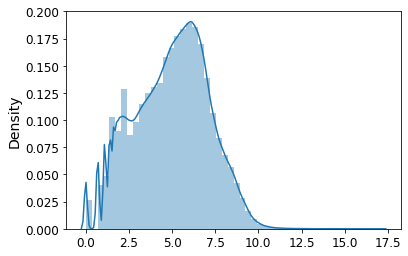

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(X_train_values)

- <p> Log dönüştürülmüş eğitim veri setinin minimum değeri 0 ve maksimum 9 civarındadır. 0-1 aralığındaki tüm veri noktalarını daha da küçültmek için bu log dönüştürülmüş eğitim veri seti üzerine bir minmax ölçekleyici uygulayacağız.

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# X_train_values üzerinde fit edip daha sonra dönüştürüyoruz. 
X_train_normalized = scaler.fit_transform(X_train_values)

# y_train
y_train_normalized = scaler.transform(y_train)


# X_Valid
X_valid_values = X_valid.reshape(-1, 1)
X_valid_normalized = scaler.transform(X_valid_values)

# y_valid
y_valid_normalized = scaler.transform(y_valid)

#X_test
X_test_values = X_test.reshape(-1, 1)
X_test_normalized = scaler.transform(X_test_values)

#y_test
y_test_normalized = scaler.transform(y_test)

# Normalleştirilmiş değerleri yeniden 3 boyutlu olarak şekillendiriyoruz.
X_train = X_train_normalized.reshape(X_train.shape[0] , X_train.shape[1] , X_train.shape[2])
X_valid = X_valid_normalized.reshape(X_valid.shape[0] ,X_valid.shape[1] , X_valid.shape[2])
X_test = X_test_normalized.reshape(X_test.shape[0] ,X_test.shape[1] , X_test.shape[2])

y_train = y_train_normalized.reshape(y_train.shape[0], y_train.shape[1] )
y_valid = y_valid_normalized.reshape(y_valid.shape[0], y_valid.shape[1] )
y_test =  y_test_normalized.reshape(y_test.shape[0], y_test.shape[1] )

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((70000, 151, 1),
 (70000, 1),
 (20000, 151, 1),
 (20000, 1),
 (10000, 151, 1),
 (10000, 1))

In [37]:
# Yaptığımız dönüşümleri yeniden ölçeklendirme işlevi,
# bu, zaman serisi tahminimizden sonra değerleri orijinal değerlere yeniden dönüştürmek için kullanılacaktır.

def reverse_transform(arr):
    
    #print(arr.shape)
    arr = arr.reshape(-1,1)
    
    ## İlk önce minmax ölçeklendirme işlemini tersine çevirin
    arr_inv_normal = scaler.inverse_transform(arr)
    
    ## log dönüşümünü ters çevirip ve 1 çıkarıyoruz.(Hatırlatma: Veri seti içerisinde 0.0 değerleri olduğu için,verilere 1 eklemiştik.) 

    arr_reverse = np.exp(arr_inv_normal ) - 1
    return (arr_reverse)

## LSTM ( Long, Short-Term Memory network )
- Kısaca LSTM'in ne olduğuna değinmek gerekirse, doğal dil işleme ve zaman serisi tahmininde yaygın olarak kullanılan Tekrarlayan Sinir Ağı (RNN) tabanlı bir mimaridir.Bir Tekrarlayan Sinir Ağı (RNN), bağlantıları yönlendirilmiş bir döngü oluşturduğu için dizi problemleriyle ilgilenir.Yani bir sonraki adım için girdi olarak kendi çıktılarını kullanarak bir yinelemeden diğerine durumu koruyabilirler. tekrarlayan sinir ağı, yalnızca kısa süreli bir bellek için iyi çalışır. Daha uzun bir zaman aralığımız varsa, temel bir sorundan (Vanishing Gradient Problemi) muzdarip olduğunu göreceğiz. Uzun Kısa Süreli Bellek (LSTM), gradyan sorununun üstesinden gelmek için geliştirilmiş bir RNN mimarisidir.Çalışma mantığı açısından RNN'den farklı olmamakla birlikte çok daha uzun dizilerin çalışmasına imkan vermektedir. RNN'ye göre, gradyan problemini büyük ölçüde çözebilir.
- LSTM, bir hücre(Cell State) , bir giriş kapısı(Input Gate), bir çıkış kapısı(Output Gate)ve bir unutma kapısından(Forget Gate) oluşur. Bir hücre, değerleri otokratik bir zaman aralığında hatırlar. Giriş kapısı, hücrenin içine gelen bilgi akışını yönetir. Çıkış kapısı, dışarıya giden bilgi akışını yönetir. Benzer şekilde, unutulan kapılar, hangi bilginin tutulacağı veya unutulacağına karar verir, bilgi akışını yönetir. LSTM tahminler yapmak, sınıflandırmak ve sıralı verileri işlemek için kullanışlıdır. 

In [38]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((70000, 151, 1), (70000, 1), (20000, 151, 1), (20000, 1))

Modelimizi eğitme aşamasına geçelim. Eğitim için, modelimizdeki ‘fit ()’ işlevini aşağıdaki yedi parametre ile birlikte kullanacağız: 
- X_train: eğitim verileri
- y_train: hedef veriler, 
- doğrulama seti(validation_data),
- batch_size: batch sayısı modelin eğitilmesi aşamasında aynı anda kaç adet verinin işleneceği anlamına gelir.
- Verbose: eğitim sırasında çıktıları görebilmek için verbose parametresinia kullanırız verbose'un 1 olmasının anlamı eğitim sırasında ekranda anlık olarak güncellenen sonuçları gösteriyor olmasıdır.
- Epoch sayısı: Veri setinin kaç kez model üzerinden geçerek eğitileceğini belirler.
- Early stopping: modelin gelişimini tamamladığı noktada eğitimi durdurur.

In [51]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Lambda
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True), 
    keras.layers.LSTM(20),
    keras.layers.Dense(1)  
])

optimizer = keras.optimizers.Adam(lr=0.0005)

lstm_model.compile(loss="mse", optimizer=optimizer)
lstm_model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = keras.callbacks.ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


history_lstm = lstm_model.fit(X_train, y_train, epochs=80, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping, mc])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_4 (LSTM)               (None, None, 20)          3280      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 8,341
Trainable params: 8,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
2188/2188 [==============================] - ETA: 0s - loss: 1.0135
Epoch 1: val_loss improved from inf to 0.20848, saving model to best_model_lstm.h5
2188/2188 [===========

In [52]:
lstm_model = keras.models.load_model('best_model_lstm.h5')

In [53]:
round(lstm_model.evaluate(X_valid, y_valid), 7)

625/625 [==============================] - 19s 28ms/step - loss: 0.1043


0.1043285

In [54]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([0, 50, 0, 0.6])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

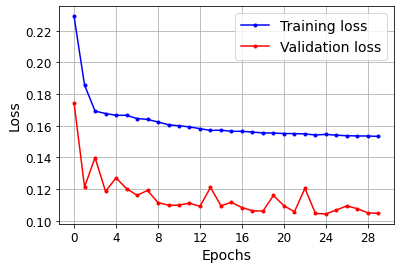

In [55]:
plot_learning_curves(history_lstm.history["loss"][1:], history_lstm.history["val_loss"][1:])
plt.show()

In [56]:
y_pred_lstm = lstm_model.predict(X_valid)


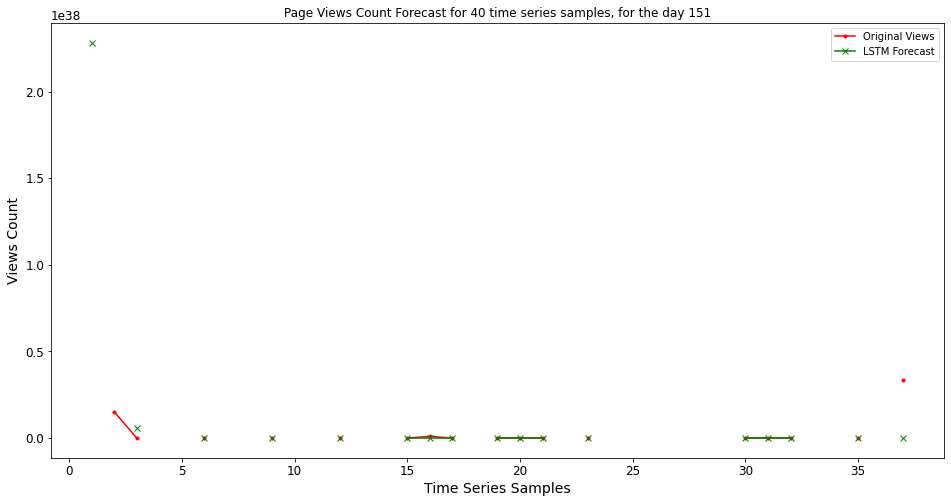

In [57]:
plt.figure(figsize=(16,8))

num_samples = 40

plt.plot(reverse_transform(y_valid[0:num_samples]), 'r.-', label = 'Original Views')
plt.plot(reverse_transform(y_pred_lstm[0:num_samples]), 'gx-', label = 'LSTM Forecast')


plt.title('Page Views Count Forecast for ' + str(num_samples) + ' time series samples, for the day ' + str(predicted_time_step))
plt.xlabel("Time Series Samples")
plt.ylabel("Views Count")
plt.legend(loc = 'best')